In [1]:
from NonlinearController.model_utils import *
from NonlinearController.systems import UnbalancedDisc
from matplotlib import pyplot as plt
import deepSI
from casadi import *
import torch
import random

In [2]:
##################  Utility functions  #######################

def randomLevelReference(Nsim, nt_range, level_range):
    x_reference_list = np.array([])
    Nsim_remaining = Nsim
    while True:
        Nsim_steps = random.randint(nt_range[0],nt_range[1])
        Nsim_remaining = Nsim_remaining - Nsim_steps
        x_reference_list = np.hstack((x_reference_list, np.ones(Nsim_steps)*random.randint(level_range[0]*10,level_range[1]*10)/10))

        if Nsim_remaining <= 0:
            x_reference_list = x_reference_list[:Nsim]
            break
    return x_reference_list

def setPointInput(y_ref):
    g = 9.80155078791343
    J = 0.000244210523960356
    Km = 10.5081817407479
    I = 0.0410772235841364
    M = 0.0761844495320390
    tau = 0.397973147009910

    return (tau * M * g * I)/(Km * J) * np.sin(y_ref)

In [3]:
##################  System  #######################
dt = 0.1
system = UnbalancedDisc(dt=dt)
system.reset_state()

##################  MPC variable specification  #######################
model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")
Nc=10; nr_sim_steps = 150

Q = 100; R = 1

w_min = -4.0; w_max = 4.0
q_min = [-1.8]; q_max = [1.8]
w0 = 0; q0 = 0

reference = randomLevelReference(nr_sim_steps+Nc, [20,25], [-1.3,1.3])
# reference = deepSI.deepSI.exp_design.multisine(nr_sim_steps+Nc+1, pmax=20, n_crest_factor_optim=20)/2.0

In [4]:
##################  Offline Computation  #######################
nx = model.nx
x = MX.sym("x",nx,1)
nu = model.nu if model.nu is not None else 1
u = MX.sym("u",nu,1)
ny = model.ny if model.ny is not None else 1

# convert torch nn to casadi function
x_rhs = CasADi_Fn(model, x, u)
f = Function('f', [x, u], [x_rhs])
y_rhs = CasADi_Hn(model, x)
h = Function('h', [x], [y_rhs])

# normalize initial input and output
norm = model.norm
u0 = norm_input(w0, norm)
y0 = norm_output(q0, norm)

u_min = norm_input(w_min, norm); u_max = norm_input(w_max, norm)
y_min = norm_output(q_min, norm); y_max = norm_output(q_max, norm)

# initialize observer history input and output
nb = model.nb
uhist = torch.ones((1,nb))*u0
na = model.na
yhist = torch.ones((1,na+1))*y0

# define initial predicted states and inputs
X0 = np.tile(model.encoder(uhist,yhist).detach().numpy().T,Nc+1)
U0 = np.ones((Nc)*nu)[np.newaxis]*u0
Y0 = np.ones((Nc)*ny)[np.newaxis]*y0

# define opti stack
opti  = Opti()

states = opti.variable(nx, Nc+1)
controls = opti.variable(nu, Nc)
outputs = opti.variable(ny, Nc)

x_initial = opti.parameter(nx, 1)
y_ref = opti.parameter(ny, Nc)
u_ref = opti.parameter(nu, Nc)

opti.subject_to(opti.bounded(y_min,outputs,y_max))
opti.subject_to(opti.bounded(u_min,controls,u_max))
opti.subject_to(states[:,0] == x_initial)

opti.set_initial(states, X0)
opti.set_initial(controls, U0)
opti.set_initial(outputs, Y0)

opti.set_value(x_initial,X0[:,0])
# opti.set_value(y_ref, reference[:Nc])

opts = {'print_time' : 0, 'ipopt': {'print_level': 0}}
opti.solver("ipopt",opts)

objective = 0
for i in np.arange(Nc):
    opti.subject_to(states[:,i+1] == f(states[:,i], controls[:,i]))
    opti.subject_to(outputs[:,i] == h(states[:,i+1]))
    objective = (objective + 
                    mtimes(mtimes((outputs[:,i] - y_ref[:,i]).T,Q),(outputs[:,i] - y_ref[:,i])) +
                    mtimes(mtimes((controls[:,i] - u_ref[:,i]).T,R),(controls[:,i] - u_ref[:,i])))

opti.minimize(objective)

##################  Logging  #######################
log_q = np.zeros((ny,nr_sim_steps))
log_w = np.zeros((nu,nr_sim_steps))

In [5]:
##################  Online Computation  #######################

#++++++++++++++++++ start simulation step +++++++++++++++++++++++
for k in range(nr_sim_steps):
    opti.set_value(y_ref, norm_output(reference[k:k+Nc], norm))
    opti.set_value(u_ref, norm_input(setPointInput(reference[k:k+Nc]), norm))
    
    sol = opti.solve()

    U0[0,:] = sol.value(controls)
    X0[:,:] = sol.value(states)
    Y0[:,:] = sol.value(outputs)

    # determine input from optimal velocity input
    u0 = U0[:,0]
    # denormalize input
    w0 = denorm_input(u0, norm)
    # measure output then apply input
    system.x = system.f(system.x, w0[0])
    q1 = system.h(system.x, w0[0])
    # normalize output
    y1 = norm_output(q1, norm)

    # shift history input and output for encoder
    for j in range(nb-1):
        uhist[0,j] = uhist[0,j+1]
    uhist[0,nb-1] = torch.Tensor(u0)
    for j in range(na):
        yhist[0,j] = yhist[0,j+1]
    yhist[0,na] = torch.Tensor([y1])
    # predict state with encoder
    x1 = model.encoder(uhist,yhist)

    # shift predicted states, input, and output one time step k
    X0[:, :-1] = X0[:, 1:]; X0[:, -1:] = X0[:, -2:-1]; X0[:, :1] = x1.detach().numpy().T
    U0[:, :-1] = U0[:, 1:]; U0[:, -1:] = U0[:, -2:-1]#; U0[:, :1] = u0
    Y0[:, :-1] = Y0[:, 1:]; Y0[:, -1:] = Y0[:, -2:-1]; Y0[:, :1] = y1

    opti.set_initial(states, X0)
    opti.set_initial(controls, U0)
    opti.set_initial(outputs, Y0)
    opti.set_value(x_initial,X0[:,0])

    # log system signals
    log_q[:,k] = q1
    log_w[:,k] = w0

    # print progress
    print("Sim step: " + str(k))
    
#++++++++++++++++++ end simulation step +++++++++++++++++++++++



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Sim step: 0
Sim step: 1
Sim step: 2
Sim step: 3
Sim step: 4
Sim step: 5
Sim step: 6
Sim step: 7
Sim step: 8
Sim step: 9
Sim step: 10
Sim step: 11
Sim step: 12
Sim step: 13
Sim step: 14
Sim step: 15
Sim step: 16
Sim step: 17
Sim step: 18
Sim step: 19
Sim step: 20
Sim step: 21
Sim step: 22
Sim step: 23
Sim step: 24
Sim step: 25
Sim step: 26
Sim step: 27
Sim step: 28
Sim step: 29
Sim step: 30
Sim step: 31
Sim step: 32
Sim step: 33
Sim step: 34
Sim step: 35
Sim step: 36
Sim step: 37
Sim step: 38
Sim step: 39
Sim step: 40
Sim step: 41
Sim step: 42
Sim step: 43
Sim step: 44
Sim step: 45
Sim step: 46
Sim step: 4

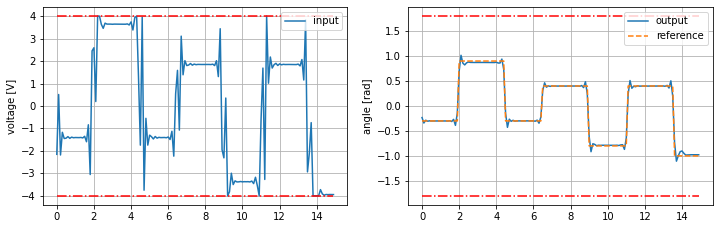

In [6]:
fig1 = plt.figure(figsize=[12, 8])

plt.subplot(2,2,1)
plt.plot(np.arange(nr_sim_steps)*dt, log_w[0,:], label='input')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_max, 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*w_min, 'r-.')#, label='min')
# plt.xlabel("time [s]")
plt.ylabel("voltage [V]")
plt.grid()
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.plot(np.arange(nr_sim_steps)*dt, log_q[0,:], label='output')
plt.plot(np.arange(nr_sim_steps)*dt, reference[:nr_sim_steps], '--', label='reference')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_max[0], 'r-.')#, label='max')
plt.plot(np.arange(nr_sim_steps)*dt, np.ones(nr_sim_steps)*q_min[0], 'r-.')#, label='min')
# plt.xlabel("time [s]")
plt.ylabel("angle [rad]")
plt.grid()
plt.legend(loc='upper right')

plt.show()